# Visualize the Data from Neo4j

In [55]:
import os
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
from dotenv import load_dotenv
from pathlib import Path 
import matplotlib.pyplot as plt
import psycopg2
from dash import Dash, html, dash_table, dcc
from dash.dependencies import Input, Output
import plotly.express as px

## CYPHER queries

In [56]:
check_query = """
OPTIONAL MATCH (n) WITH n LIMIT 1 
RETURN n IS NOT NULL AS IsNodesPresent
"""
country_query = """
MATCH (n:country) RETURN n.code as Code, n.zone as Zone, n.name as Name LIMIT 25
"""

emission_by_country_query = """
MATCH (c:country)-[r1:UNDER_IPCC_CODE]->(i:ipcc)-[r2:HAS_PRODUCED]->(e:emission)
WITH c,i,e,r1,r2
WHERE c.code = '{key}'
RETURN
    c.code as Code,
    c.zone as Zone,
    c.name as Name,
    i.ipcc_code as IPCC_Code,
    i.ipcc_name as IPCC_Code_Name,
    e.total_emission as Total_Emission
    ORDER BY Code
"""

emission_by_country_year_query = """
MATCH (c:country)-[r1:UNDER_IPCC_CODE]->(i:ipcc)-[r2:HAS_PRODUCED]->(e:emission)
WITH c,i,e,r1,r2
WHERE i.ipcc_code = '{key1}'
RETURN
    c.code as Code,
    c.zone as Zone,
    c.name as Name,
    i.ipcc_code as IPCC_Code,
    i.ipcc_name as IPCC_Code_Name,
    e.`{key2}` as Y_{key2},
    e.total_emission as Total_Emission
    ORDER BY Code
"""

emission_by_secotrs_query = """
MATCH (c:country)-[r1:UNDER_IPCC_CODE]->(i:ipcc)-[r2:HAS_PRODUCED]->(e:emission)
WITH c,i,e,r1,r2
WHERE i.ipcc_code = '{key}'
RETURN
    c.name as Country_Name,
    i.ipcc_code as Code,
    i.ipcc_name as Name, 
    e.total_emission as Total_Emission
"""
complete_emission_query="""
MATCH (c:country)-[r1:UNDER_IPCC_CODE]->(i:ipcc)-[r2:HAS_PRODUCED]->(e:emission)
WITH c,i,e,r1,r2
RETURN
    c.code as Code,
    c.zone as Zone,
    c.name as Name,
    i.ipcc_code as IPCC_Code,
    i.ipcc_name as IPCC_Code_Name,
    properties(e) as emissions
ORDER BY Code
"""

## Neo4j connection

In [57]:
def connectToDataBases():
    load_dotenv(verbose=True)
    env_path = Path('../../') / '.env'
    if(load_dotenv(dotenv_path=env_path)):
        host = os.environ.get("neo_host")
        username = os.environ.get("neo_username")
        password = os.environ.get("neo_password")
    else:
        print(".env file does not have required values!")
    driver = GraphDatabase.driver(host,auth=(username, password))
    return driver

In [58]:
def getCountry(query,name=""):
    with driver.session() as session: 
        result = session.run(query)
        data = [dict(record) for record in result]
        return pd.DataFrame(data)

In [59]:
def getRecords(query, values=[]):
    with driver.session() as session:
        f_query = ""
        if(len(values) > 0):
            if(len(values) == 1):
                f_query = query.format(key=values[0])
            elif(len(values) == 2):
                f_query = query.format(key1=values[0],key2=values[1])
            else:
                f_query = query
        else:
            f_query = query
        result = session.run(f_query)
        data = [dict(record) for record in result]
        return pd.DataFrame(data)

In [60]:
driver = connectToDataBases()

In [61]:
# getCountry(country_query)

In [62]:
emission_by_country = getRecords(emission_by_country_query,["ABW"])

In [63]:
emission_by_secotrs= getRecords(emission_by_secotrs_query,["1.A.3.d"])

In [64]:
emission_by_country_year = getRecords(emission_by_country_year_query,["1.A.3.d","2020"])

In [65]:
init_complete_emission = getRecords(complete_emission_query)

In [66]:
# init_complete_emission

In [67]:
def createCompleteData(df):
    records=[]
    for i, row in df.iterrows():
        emission_body={
            'Code':row["Code"],
            'Zone':row["Zone"],
            'Name':row["Name"],
            'IPCC_Code':row["IPCC_Code"],
            'IPCC_Code_Name':row["IPCC_Code_Name"],
        }
        for year_col in sorted(col for col in row['emissions'].keys()):
            emission_body[f"{year_col}"] = row['emissions'][year_col]
        records.append(emission_body)
    return pd.DataFrame(records)

In [68]:
complete_emission = createCompleteData(init_complete_emission)

In [69]:
year_cols = [col for col in complete_emission.columns if col.isdigit()]

## PostgreSQL connection

In [70]:
def connectToDB(db = "postgres"):
    try:
        load_dotenv(verbose=True)
        env_path = Path('../../') / '.env'
        if(load_dotenv(dotenv_path=env_path)):
            _host = os.environ.get("pg_host")
            _username = os.environ.get("pg_username")
            _password = os.environ.get("pg_password")
            _port = int(os.environ.get("pg_port"))
            conn = psycopg2.connect(database=db,
                    host=_host,
                    user=_username,
                    password=_password,
                    port=_port)
            return conn
        else:
            return None
    except (psycopg2.DatabaseError, Exception) as error:
        print(error)

In [71]:
conn = connectToDB("co2_emission")
cursor = conn.cursor()

In [72]:
all_county_query = """SELECT code FROM country"""

emission_by_year = """SELECT c.name,sum(e.Y_{year}) AS emission_rate FROM emission e 
INNER JOIN country c ON e.country_id = c.country_id GROUP BY c.name;"""

In [73]:
cursor.execute(all_county_query)
country_list = [str(country[0]) for country in cursor.fetchall()]

In [74]:
def getEmissionByYear(query,value="2000"):
    cursor.execute(query.format(year=value))
    return cursor.fetchall()

In [75]:
emissionByYear = getEmissionByYear(emission_by_year)
map_plot={
        "country":[str(x[0]) for x in emissionByYear],
        "emission":[str(x[1]) for x in emissionByYear]
}

## Visalization

<Figure size 1200x800 with 0 Axes>

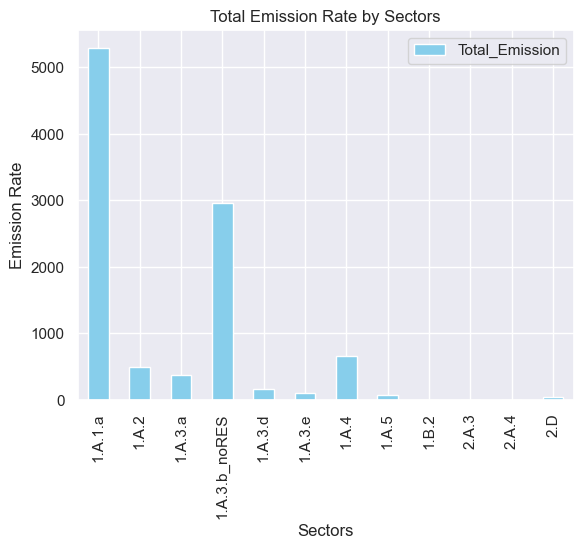

In [76]:
plt.figure(figsize=(12,8))
emission_by_country.plot(x="IPCC_Code",y="Total_Emission",kind="bar",color="skyblue")
plt.title("Total Emission Rate by Sectors")
plt.ylabel("Emission Rate")
plt.xlabel("Sectors")
plt.xticks(rotation=90)
plt.show()

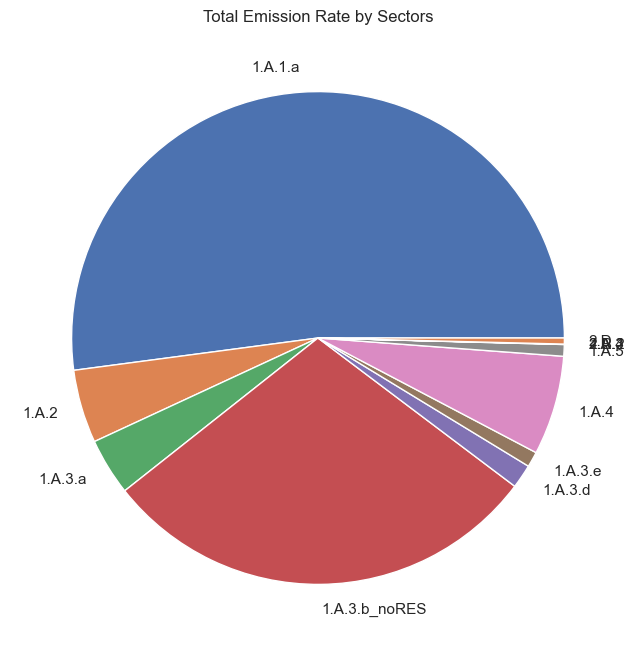

In [77]:
plt.figure(figsize=(8,8))
plt.pie(x=emission_by_country["Total_Emission"],labels=emission_by_country["IPCC_Code"])
plt.title("Total Emission Rate by Sectors")
plt.show()

In [78]:
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
# complete_emission.plot(x="IPCC_Code",y=year_cols,kind="line",ax=ax1, marker='o')
# ax1.set_title("Emission Trend")
# ax1.set_ylabel('Rmission Rates')

# complete_emission.plot(x="IPCC_Code",y=year_cols,kind="bar",ax=ax2)
# ax2.set_title("Emission Comparison over the years")
# ax2.set_ylabel('Rmission Rates')

# plt.tight_layout()
# plt.show()

<Figure size 1200x600 with 0 Axes>

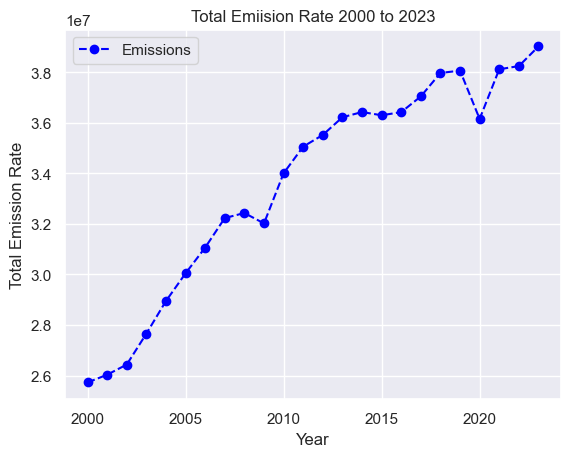

In [79]:
plot_data = {
    "Year":year_cols,
    'Emissions':complete_emission[year_cols].sum().values
}
plot_df=pd.DataFrame(plot_data)

plt.figure(figsize=(12,6))
plot_df.plot(x="Year",y="Emissions", kind="line",marker='o',linestyle="--",color="blue")
plt.title("Total Emiision Rate 2000 to 2023")
plt.xlabel("Year")
plt.ylabel("Total Emission Rate")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

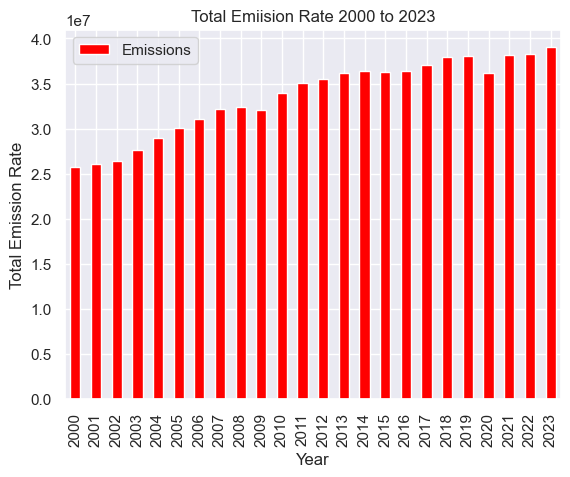

In [80]:
plt.figure(figsize=(12,6))
plot_df.plot(x="Year",y="Emissions", kind="bar",color="red")
plt.title("Total Emiision Rate 2000 to 2023")
plt.xlabel("Year")
plt.ylabel("Total Emission Rate")
plt.show()

## Dashboard

In [81]:
app = Dash()

# App layout
app.layout = [
    html.Div(children='My First App with Data and a Graph'),
    dcc.Graph(figure=px.histogram(plot_df, x='Year', y='Emissions', histfunc='avg')),
    dcc.Graph(figure=px.line(plot_df,x='Year',y='Emissions')),
    dcc.Dropdown(country_list, "BRA", id="country-dropdown"),
    html.Div(id="dd-output-container"),
    dcc.Graph(id="country-graph"),
    dcc.Graph(id="country-ipcc-pie-graph"),
    dcc.Dropdown([str(i) for i in range(2000,2024)], "2000", id="year-dropdown"),
    dcc.Graph(id="continent-map"),
]


In [82]:
@app.callback(
    Output('country-graph', 'figure'),
    Input('country-dropdown', 'value')
)

def update_bar(value):
    emission_by_country = getRecords(emission_by_country_query,[value])
    graph_df = emission_by_country[emission_by_country["Code"] == value]

    fig = px.bar(graph_df,x="IPCC_Code",y="Total_Emission")
    return fig

In [83]:
@app.callback(
    Output('country-ipcc-pie-graph', 'figure'),
    Input('country-dropdown', 'value')
)
def update_pie(value):
    emission_by_country = getRecords(emission_by_country_query,[value])
    graph_df = emission_by_country[emission_by_country["Code"] == value]

    fig = px.pie(graph_df, values='Total_Emission', names='IPCC_Code', title=f'Emission by IPCC code for {graph_df["Name"][0]}').update_traces(textposition='inside', textinfo='percent+label')
    return fig

In [84]:
red_scale = [
    [0.0, 'rgb(103, 0, 0)'], 
    [0.2, 'rgb(178, 24, 43)'],
    [0.4, 'rgb(214, 96, 77)'],
    [0.6, 'rgb(244, 165, 130)'],
    [0.8, 'rgb(253, 219, 199)'],
    [1.0, 'rgb(255, 245, 240)']
]

In [85]:
@app.callback(
    Output('continent-map', 'figure'),
    Input('year-dropdown', 'value')
)
def update_country_emission(value):
    emissionByYear = getEmissionByYear(emission_by_year,value)
    map_plot={
        "country":[str(x[0]) for x in emissionByYear],
        "emission":[int(x[1]) for x in emissionByYear]
    }
    graph_df = pd.DataFrame(map_plot)
    values = graph_df["emission"]
    fig = px.choropleth(graph_df,
                       locations="country",
                       locationmode="country names",
                       color="emission",
                       scope="europe",
                       title="Emission by Country",
                       hover_name = "country",
                       hover_data = {"emission":True,"country":False},
                       labels={"emission":"Emission Rate"},
                       )
    fig.update_geos(showcountries=True, showcoastlines=True)
    fig.update_layout(height=600,coloraxis_colorbar={"title":"emission","tickformat":",.0f"})
    return fig

In [86]:
# app = Dash(__name__)


# app.layout = html.Div([
#     html.H4('Political candidate voting pool analysis'),
#     html.P("Select a candidate:"),
#     dcc.RadioItems(
#         id='candidate',
#         options=["Joly", "Coderre", "Bergeron"],
#         value="Coderre",
#         inline=True
#     ),
#     dcc.Graph(id="graph"),
# ])


# @app.callback(
#     Output("graph", "figure"),
#     Input("candidate", "value"))
# def display_choropleth(candidate):
#     df = px.data.election() # replace with your own data source
#     geojson = px.data.election_geojson()
#     fig = px.choropleth(
#         df, geojson=geojson, color=candidate,
#         locations="district", featureidkey="properties.district",
#         projection="mercator", range_color=[0, 6500])
#     fig.update_geos(fitbounds="locations", visible=False)
#     fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#     return fig


# app.run(debug=True)

In [88]:
# # Run the app
# if __name__ == '__main__':
#     app.run(debug=True,jupyter_mode="tab")